In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# True USES REGRESSION, False USES CLASSIFICATION
USE_REGRESSION = True

# VERSION NUMBER FOR NAMING OF SAVED MODELS
VER=1

# IF "LOAD_FROM" IS None, THEN WE TRAIN NEW MODELS
LOAD_FROM = "/kaggle/input/deberta-v3-small-finetuned-v1/"

# WHEN TRAINING NEW MODELS SET COMPUTE_CV = True
# WHEN LOADING MODELS, WE CAN CHOOSE True or False
COMPUTE_CV = True

In [2]:
import warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from tokenizers import AddedToken
warnings.simplefilter('ignore')

2024-05-03 14:13:16.553274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 14:13:16.553378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 14:13:16.711069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class PATHS:
    train_path = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv'
    test_path = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv'
    sub_path = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv'
    model_path = "/kaggle/input/huggingfacedebertav3variants/deberta-v3-small"

In [4]:
class CFG:
    n_splits = 5
    seed = 42
    max_length = 1024
    lr = 1e-5
    train_batch_size = 4
    eval_batch_size = 8
    train_epochs = 4
    weight_decay = 0.01
    warmup_ratio = 0.0
    num_labels = 6

In [5]:
def seed_everything(seed):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed=CFG.seed)

In [6]:
class Tokenize(object):
    def __init__(self, train, valid, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
        self.valid = valid
        
    def get_dataset(self, df):
        ds = Dataset.from_dict({
                'essay_id': [e for e in df['essay_id']],
                'full_text': [ft for ft in df['full_text']],
                'label': [s for s in df['label']],
            })
        return ds
        
    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example['full_text'], truncation=True, max_length=CFG.max_length
        )
        return tokenized_inputs
    
    def __call__(self):
        train_ds = self.get_dataset(self.train)
        valid_ds = self.get_dataset(self.valid)
        
        tokenized_train = train_ds.map(
            self.tokenize_function, batched=True
        )
        tokenized_valid = valid_ds.map(
            self.tokenize_function, batched=True
        )
        
        return tokenized_train, tokenized_valid, self.tokenizer

In [7]:
def compute_metrics_for_regression(eval_pred):
    
    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.clip(0,5).round(0), weights='quadratic')
    results = {
        'qwk': qwk
    }
    return results

In [8]:
def compute_metrics_for_classification(eval_pred):
    
    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights='quadratic')
    results = {
        'qwk': qwk
    }
    return results

In [9]:
data = pd.read_csv(PATHS.train_path)
data['label'] = data['score'].apply(lambda x: x-1)
if USE_REGRESSION: data["label"] = data["label"].astype('float32') 
else: data["label"] = data["label"].astype('int32') 

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val_index) in enumerate(skf.split(data, data["score"])):
    data.loc[val_index, "fold"] = i
data.head()

,essay_id,full_text,score,label,fold
0,000d118,Many people have car where they live. The thin...,3,2.0,3.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,2.0,4.0
2,001ab80,People always wish they had the same technolog...,4,3.0,1.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,3.0,0.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2.0,2.0


In [10]:
training_args = TrainingArguments(
    output_dir=f'output_v{VER}',
    fp16=True,
    learning_rate=CFG.lr,
    per_device_train_batch_size=CFG.train_batch_size,
    per_device_eval_batch_size=CFG.eval_batch_size,
    num_train_epochs=CFG.train_epochs,
    weight_decay=CFG.weight_decay,
    evaluation_strategy='epoch',
    metric_for_best_model='qwk',
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to='none',
    warmup_ratio=CFG.warmup_ratio,
    lr_scheduler_type='linear', # "cosine" or "linear" or "constant"
    optim='adamw_torch',
    logging_first_step=True,
)

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

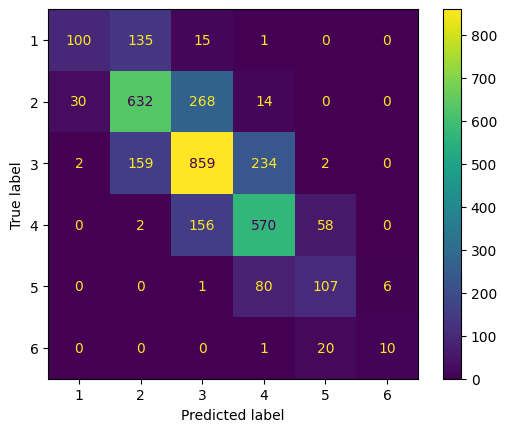

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

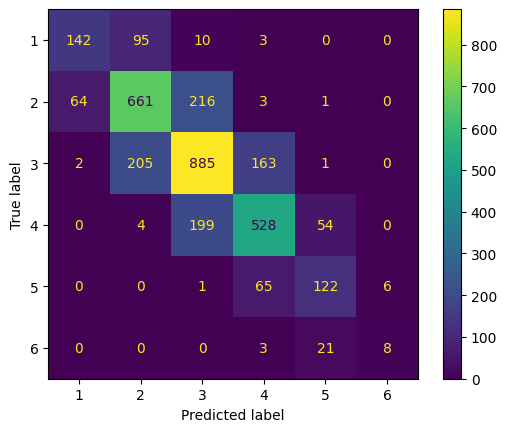

Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

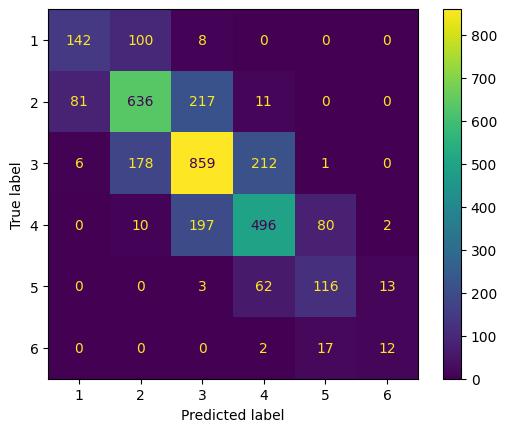

Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

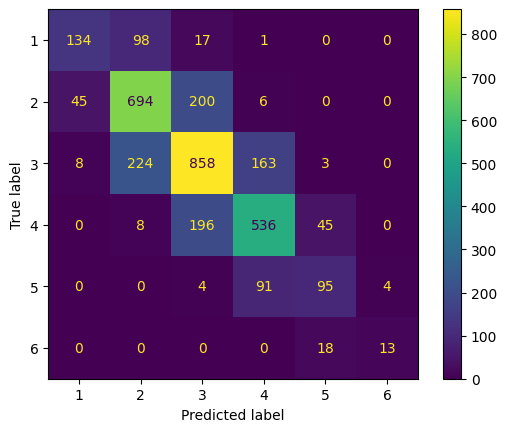

Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

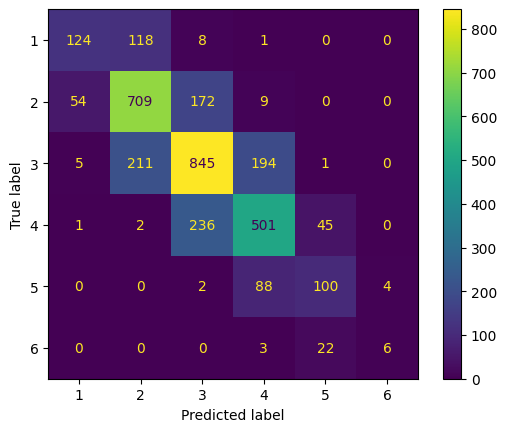

In [11]:
if COMPUTE_CV:
    for fold in range(len(data['fold'].unique())):

        # GET TRAIN AND VALID DATA
        train = data[data['fold'] != fold]
        valid = data[data['fold'] == fold].copy()

        # ADD NEW TOKENS for ("\n") new paragraph and (" "*2) double space 
        tokenizer = AutoTokenizer.from_pretrained(PATHS.model_path)
        tokenizer.add_tokens([AddedToken("\n", normalized=False)])
        tokenizer.add_tokens([AddedToken(" "*2, normalized=False)])
        tokenize = Tokenize(train, valid, tokenizer)
        tokenized_train, tokenized_valid, _ = tokenize()

        # REMOVE DROPOUT FROM REGRESSION
        config = AutoConfig.from_pretrained(PATHS.model_path)
        if USE_REGRESSION:
            config.attention_probs_dropout_prob = 0.0 
            config.hidden_dropout_prob = 0.0 
            config.num_labels = 1 
        else: config.num_labels = CFG.num_labels 

        if LOAD_FROM:
            model = AutoModelForSequenceClassification.from_pretrained(LOAD_FROM + f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
        else:
            model = AutoModelForSequenceClassification.from_pretrained(PATHS.model_path, config=config)
            model.resize_token_embeddings(len(tokenizer))

        # TRAIN WITH TRAINER
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        if USE_REGRESSION: compute_metrics = compute_metrics_for_regression
        else: compute_metrics = compute_metrics_for_classification
        trainer = Trainer( 
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_valid,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )
        if LOAD_FROM is None:
            trainer.train()

        # PLOT CONFUSION MATRIX
        y_true = valid['score'].values
        predictions0 = trainer.predict(tokenized_valid).predictions
        if USE_REGRESSION: predictions = predictions0.round(0) + 1
        else: predictions = predictions0.argmax(axis=1) + 1 
        cm = confusion_matrix(y_true, predictions, labels=[x for x in range(1,7)])
        draw_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(1,7)])
        draw_cm.plot()
        plt.show()

        # SAVE FOLD MODEL AND TOKENIZER
        if LOAD_FROM is None:
            trainer.save_model(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
            tokenizer.save_pretrained(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')

        # SAVE OOF PREDICTIONS
        if USE_REGRESSION: 
            valid['pred'] = predictions0 + 1 
        else:
            COLS = [f'p{x}' for x in range(CFG.num_labels)] 
            valid[COLS] = predictions0 
        valid.to_csv(f'valid_df_fold_{fold}_v{VER}.csv', index=False)

In [12]:
if COMPUTE_CV:
    dfs = []
    for k in range(CFG.n_splits):
        dfs.append( pd.read_csv('/kaggle/input/deberta-v3-small-finetuned-v1/valid_df_v1.csv') )
        os.system(f'rm valid_df_fold_{k}_v{VER}.csv')
    dfs = pd.concat(dfs)
    dfs.to_csv(f'valid_df_v{VER}.csv',index=False)
    print('Valid OOF shape:', dfs.shape )
    display( dfs.head() )

Valid OOF shape: (86535, 6)


,essay_id,full_text,score,label,fold,pred
0,001bdc0,"We all heard about Venus, the planet without a...",4,3.0,0.0,3.586036
1,0033037,The posibilty of a face reconizing computer wo...,2,1.0,0.0,2.445031
2,0066c7c,My position on driveless cars are bad because ...,2,1.0,0.0,2.492580
3,0072128,"Imagine a world without garages, gastations, o...",4,3.0,0.0,3.893263
4,0079f2a,In the text the author uses facts that people ...,2,1.0,0.0,1.570877


In [13]:
if COMPUTE_CV:
    if USE_REGRESSION:
        m = cohen_kappa_score(dfs.score.values, dfs.pred.values.clip(1,6).round(0), weights='quadratic')
    else:
        m = cohen_kappa_score(dfs.score.values, dfs.iloc[:,-6:].values.argmax(axis=1)+1, weights='quadratic')
    print('Overall QWK CV =',m)

Overall QWK CV = 0.822075073743795


In [14]:
test = pd.read_csv(PATHS.test_path)
print('Test shape:', test.shape )
test.head()

Test shape: (3, 2)


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [15]:
all_pred = []
test['label'] = 0.0

for fold in range(CFG.n_splits):
    
    # LOAD TOKENIZER
    if LOAD_FROM:
        tokenizer = AutoTokenizer.from_pretrained(LOAD_FROM + f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    else:
        tokenizer = AutoTokenizer.from_pretrained(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    tokenize = Tokenize(test, test, tokenizer)
    tokenized_test, _, _ = tokenize()

    # LOAD MODEL
    if LOAD_FROM:
        model = AutoModelForSequenceClassification.from_pretrained(LOAD_FROM + f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    else:
        model = AutoModelForSequenceClassification.from_pretrained(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    
    # INFER WITH TRAINER
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainer = Trainer( 
        model=model,
        args=training_args,
        train_dataset=tokenized_test,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    # SAVE PREDICTIONS
    predictions = trainer.predict(tokenized_test).predictions
    all_pred.append( predictions )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [16]:
preds = np.mean(all_pred, axis=0)
print('Predictions shape:',preds.shape)

Predictions shape: (3,)


In [17]:
sub = pd.read_csv(PATHS.sub_path)
if USE_REGRESSION: sub["score"] = preds.clip(0,5).round(0)+1
else: sub["score"] = preds.argmax(axis=1)+1
sub.score = sub.score.astype('int32')
sub.to_csv('submission.csv',index=False)
print('Submission shape:', sub.shape )
sub.head()

Submission shape: (3, 2)


,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
